In [1]:
import numpy as np
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# 1. Load processed data
# ------------------------
X_train_balanced = np.load("data/processed/X_train_balanced.npy")
y_train_balanced = np.load("data/processed/y_train_balanced.npy")
X_test = np.load("data/processed/X_test.npy")
y_test = np.load("data/processed/y_test.npy")


In [3]:
# 2. Load feature names (optional, for plotting later)
# ------------------------
feature_names = joblib.load("models/feature_names.pkl")

In [4]:
# 3. Define models
# ------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(),
    "SVM": SVC(kernel='rbf', probability=True)
}


In [5]:
# 4. Train & Evaluate
# ------------------------
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })
    
    print(f"\n{name} Report:\n")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

Training LogisticRegression...

LogisticRegression Report:

              precision    recall  f1-score   support

           0       0.73      0.55      0.63      1021
           1       0.28      0.45      0.34       388

    accuracy                           0.52      1409
   macro avg       0.50      0.50      0.49      1409
weighted avg       0.60      0.52      0.55      1409

--------------------------------------------------
Training RandomForest...

RandomForest Report:

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1021
           1       0.53      0.02      0.04       388

    accuracy                           0.73      1409
   macro avg       0.63      0.51      0.44      1409
weighted avg       0.67      0.73      0.62      1409

--------------------------------------------------
Training GradientBoosting...

GradientBoosting Report:

              precision    recall  f1-score   support

           0       0.73  

In [8]:
# 5. Compare models
# ------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1", ascending=False)
print("\nModel comparison by F1 score:\n")
print(results_df)


Model comparison by F1 score:

                Model  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.524485   0.277603  0.453608  0.344423
3                 SVM  0.687722   0.305970  0.105670  0.157088
1        RandomForest  0.725337   0.533333  0.020619  0.039702
2    GradientBoosting  0.725337   1.000000  0.002577  0.005141


In [9]:
# 6. Select best model
# ------------------------
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
print(f"\nBest model selected: {best_model_name}")



Best model selected: LogisticRegression


In [10]:
# 7. Save best model
# ------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/best_churn_model.pkl")

# ------------------------

['models/best_churn_model.pkl']

In [11]:
# 8. Feature importance (if tree-based)
# ------------------------
if best_model_name in ["RandomForest", "GradientBoosting"]:
    importances = pd.Series(best_model.feature_importances_, index=feature_names)
    top_features = importances.sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title(f"Top 15 Features - {best_model_name}")
    plt.show()


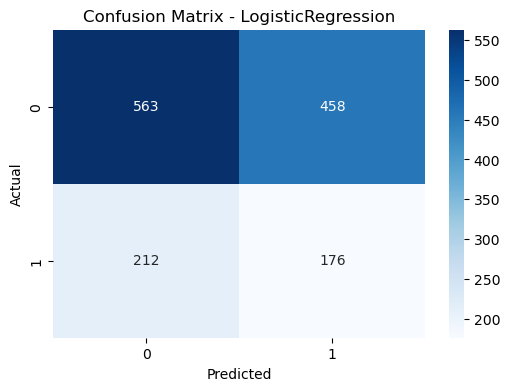

In [12]:
# 9. Confusion matrix
# ------------------------
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()